# Alternus Vera Project (Team Virgo Cluster) - Final

## Introduction

Due December 11, 2018
By Team Virgo Cluster

### About this Notebook

This python notebook downloads csv files from different sources uploaded by
the individual members of the team working on each factor(s).

After downloading the csv files, the factor columns are extracted. Using
weighted values and factor score/ranks, we generate a score to determine "fake"-ness of
each news article. Polynomial equation is provided in this notebook.

Since this notebook is the last stage of the pipeline, and generates the final
aggregated score for fake news classification, **this notebook can be
considered the official notebook of our Alternus Vera project**.

However, please refer to the **individual notebooks** and **combined (team) notebook**
to see how the individual csv files are generated one per factor. The derivations are done
in smaller notebooks, and only aggregations and generating polynomial
are done here. All relevant references are made in individual notebooks.

### About Team Virgo Cluster

###  Contributions

Sy Le (006088940) : data import and wrangling, tokenization, remove stopwords, remove stemmings, feature selection using Context of the statement and Social reliability

Mojdeh Keykhanzadeh(008129589) : remove punctuation , apply ngrams,researched about IBM Faireness , Sentiment Analysis of text , Frequency of word visualization ,Topic modeling using Gensim , finding cosine similarity score of title and text

Hyunwook Shin (012507417) : Coverage Score and Political Bias/Spectrum Analysis, Data enrichment: all news dataset (50K+ articles), political messages dataset (LDA, TF-IDF, MultinomialNB, random forrest, word2vec, doc2vec), identifying factors, and assigning weightage to individual factors.

Lin Cheng (012484459) : Interpret and transform data, use TF-IDF Vectorizer with customized tokenizer + SVD to produce a matrix, apply different classifiers and hyperparameter tuning and build a model with 95.6% accuracy

Yu Xu (012502048): Explored ways to gather topics from the dataset. Explored tf-idf ranking. Explored pipeline + GridSearch for the best n_component of LDA for logistic regression

# Notebooks

### Team Notebook

**Combined notebook** can be found here, but to cut down run time and save resources, we used individual notebooks to run distillation and scoring for each factor. So please do not run the combined notebook, but simply refer to it as the code source.

https://colab.research.google.com/drive/1bOoY6V0ytxSigKuZ6lJntNWJJcTM_6wU#scrollTo=myrJOvEVIhue

### Individual Notebooks

**Hyunwook Notebook**
https://colab.research.google.com/drive/1gOvKRrE7g7ldiNIpoYbkx3hnOW9LT66T#scrollTo=BXdP1JmmfaSp

**Mojdeh Notebook**
https://colab.research.google.com/drive/1Xz_-XGbzTdK53INTXI-WqOcDW5gWbl3o#scrollTo=XUZqgzzOIQ_M&uniqifier=2

**Sy Notebook**
https://colab.research.google.com/drive/1QfCxEI_agvoMclqVujmJskXTspUSeDAH

**Lin Notebook**
https://colab.research.google.com/drive/1dVuCq4kcgIhl9vK1CzR8EFoWqi0VzHT9

**Gene Notebook**
https://colab.research.google.com/drive/17Veeq4ovc7ToWbhTMGEcfPJ6TmOzoEHJ

(Data processing template by Gene for Aggregation)
https://colab.research.google.com/drive/1rLCLUZlNylQ0t7d_-lYaAi5GKisHn290#scrollTo=Ep7WNDIqg4pk

## Dependencies

In [1]:
# dependencies
import pandas as pd
import nltk
import numpy as np
import io
import requests
# from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_selection import chi2
from string import punctuation
from nltk import PorterStemmer
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from xgboost import XGBClassifier

nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

## Downloading Individual CSV Files (Factors)

The individual CSV files should have the same rows (fake news and all news dataset concatenated together), with articles in the same order as
prepared originally by Gene.

1. Fake news comes first before Non-fake (all) news
2. Ensuring that the counts are as follows:

```
<your_labeled_csv_data>.type.value_counts()
0    51507
1    11492
Name: type, dtype: int64
 ```
 
 3. Ensuring that the labels are complete with no "holes"

In [0]:
def get_parsed_data(url):
    return pd.read_csv(io.StringIO(requests.get(url, verify=False).content.decode('utf-8')), sep=',', header='infer')
  

### Master Dataset

In [3]:
data_kg_fake_news = get_parsed_data('https://github.com/synle/machine-learning-sample-dataset/raw/master/liar_dataset/kaggle/kaggle-fake.csv')
data_kg_fake_news.loc[data_kg_fake_news['type']!='bs', 'type'] = 0
data_kg_fake_news.loc[data_kg_fake_news['type']=='bs', 'type'] = 1

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


In [4]:
data_kg_nonfake_news = get_parsed_data('https://github.com/synle/AlternusVera/releases/download/v0/articles1.csv')
data_kg_nonfake_news.rename(columns={"content": "text"}, inplace=True)
data_kg_nonfake_news['type'] = 0

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


In [0]:
all_data = pd.concat([data_kg_fake_news[['title','text','type']], data_kg_nonfake_news[['title','text','type']]])

Verify dimensions

In [0]:
assert all_data.shape[0] == 62999, "Please review your csv" # INSERTED BY JAMES

### Gene 

In [7]:
w2v_d2v_factors = pd.read_csv(io.StringIO(requests.get('https://github.com/synle/AlternusVera/releases/download/v0/fake_news_w2v_d2v_only.csv', \
                                                       verify=False).content.decode('utf-8')), sep=',', header=None, names=['text_w2v_mean','title_w2v_mean','text_d2v_mean','title_d2v_mean'])

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


In [8]:
w2v_d2v_factors.head()

,text_w2v_mean,title_w2v_mean,text_d2v_mean,title_d2v_mean
0,-0.052476,0.066654,-0.220385,-0.114133
1,-0.126095,-0.309628,-0.048451,0.017952
2,-0.095904,-0.209579,-0.118836,-0.079925
3,-0.027249,-0.071950,-0.038647,-0.168344
4,-0.075030,-0.066515,-0.155317,-0.074950


In [0]:
assert w2v_d2v_factors.shape[0] == 62999, "Please review your csv" # INSERTED BY JAMES

### Mojdeh

In [10]:
sentiment_factors = get_parsed_data('https://raw.githubusercontent.com/mojdehkeykhanzadeh/NLP_Proj/master/all_news_sentiment.csv')

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


In [11]:
sentiment_factors

,Unnamed: 0,title_senti_neg,title_senti_neu,title_senti_pos,title_senti_cmpd,text_senti_neg,text_senti_neu,text_senti_pos,text_senti_cmp
0,0,0.4588,0.000,0.625,0.375,-0.3400,0.209,0.606,0.185
1,1,0.0000,0.000,1.000,0.000,-0.2960,0.063,0.887,0.050
2,2,0.0000,0.000,1.000,0.000,0.8957,0.021,0.871,0.108
3,3,-0.7783,0.430,0.570,0.000,0.8316,0.133,0.517,0.350
4,4,0.0000,0.000,1.000,0.000,0.9517,0.066,0.765,0.170
5,5,-0.2500,0.250,0.750,0.000,-0.9936,0.352,0.618,0.030
6,6,-0.3400,0.107,0.893,0.000,-0.9559,0.103,0.813,0.084
7,7,-0.4588,0.317,0.528,0.154,-0.9836,0.138,0.844,0.019
8,8,0.3400,0.102,0.678,0.220,0.1027,0.044,0.902,0.054
9,9,-0.4019,0.243,0.608,0.149,-0.8402,0.151,0.809,0.040


In [0]:
assert sentiment_factors.shape[0] == 62999, "Please review your csv" # INSERTED BY JAMES

### Hyunwook (James)

News event coverage scores ranging from 0 to 18 are added to the dataset

In [13]:
coverage_factor = get_parsed_data('https://github.com/synle/AlternusVera/releases/download/v0/all_data_coverage_condensed.processed.csv')

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


In [14]:
coverage_factor.head(10)

,Unnamed: 0,title,Coverage
0,0,Muslims BUSTED: They Stole Millions In Gov’t B...,0
1,1,Re: Why Did Attorney General Loretta Lynch Ple...,0
2,2,BREAKING: Weiner Cooperating With FBI On Hilla...,0
3,3,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,0
4,4,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,0
5,5,Hillary Goes Absolutely Berserk On Protester A...,0
6,6,BREAKING! NYPD Ready To Make Arrests In Weiner...,0
7,7,WOW! WHISTLEBLOWER TELLS CHILLING STORY Of Mas...,0
8,8,BREAKING: CLINTON CLEARED...Was This A Coordin...,0
9,9,"EVIL HILLARY SUPPORTERS Yell ""F*ck Trump""…Burn...",0


In [0]:
assert coverage_factor.shape[0] == 62999, "Please review your csv" # INSERTED BY JAMES

### Sy

Here we have 3 scores for reputation and social activeness, and all of them ranges from 0 to 10

*   calculated_reputation_score
*   calculated_spam_score
*   calculated_social_score

In [16]:
social_reliability_factors = get_parsed_data('https://github.com/synle/machine-learning-sample-dataset/raw/master/liar_dataset/factor_social_reliablity.csv')

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


In [17]:
social_reliability_factors

,Unnamed: 0,type,calculated_reputation_score,calculated_spam_score,calculated_social_score
0,0,0,8,0.00,0.011
1,1,0,8,0.00,0.011
2,2,0,8,0.00,0.011
3,3,0,8,0.68,0.000
4,4,0,8,8.65,0.000
5,5,0,8,0.00,0.011
6,6,0,8,7.01,0.000
7,7,0,8,1.88,0.000
8,8,0,8,1.44,0.000
9,9,0,8,9.95,0.000


In [0]:
assert social_reliability_factors.shape[0] == 62999, "Please review your csv" # INSERTED BY JAMES

### Lin

In [19]:
import pandas as pd
import io
import requests

def get_parsed_data2(url):
    return pd.read_csv(io.StringIO(requests.get(url, verify=False).content.decode('utf-8')), sep=',', header='infer', error_bad_lines=False)

# download and parse the dataset...
data_kg_fake_news2 = get_parsed_data2('https://github.com/synle/machine-learning-sample-dataset/raw/master/liar_dataset/kaggle/kaggle-fake.csv')

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


In [20]:
data_kg_nonfake_news2 = get_parsed_data2('https://github.com/synle/AlternusVera/releases/download/v0/articles1.csv')

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


In [21]:
data_kg_nonfake_news2.rename(columns={"content": "text"}, inplace=True)
data_kg_nonfake_news2['type'] = 'non-bs'
print(data_kg_nonfake_news2.shape)
data_kg_nonfake_news2.head()

(50000, 11)


,Unnamed: 0,id,title,publication,author,date,year,month,url,text,type
0,0,17283,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,2016-12-31,2016.0,12.0,NaN,WASHINGTON — Congressional Republicans have...,non-bs
1,1,17284,Rift Between Officers and Residents as Killing...,New York Times,Benjamin Mueller and Al Baker,2017-06-19,2017.0,6.0,NaN,"After the bullet shells get counted, the blood...",non-bs
2,2,17285,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,Margalit Fox,2017-01-06,2017.0,1.0,NaN,"When Walt Disney’s “Bambi” opened in 1942, cri...",non-bs
3,3,17286,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",New York Times,William McDonald,2017-04-10,2017.0,4.0,NaN,"Death may be the great equalizer, but it isn’t...",non-bs
4,4,17287,Kim Jong-un Says North Korea Is Preparing to T...,New York Times,Choe Sang-Hun,2017-01-02,2017.0,1.0,NaN,"SEOUL, South Korea — North Korea’s leader, ...",non-bs


Combine those two datasets, mark data "bias 443 bs 11492 conspiracy 430 fake 19 hate 246 junksci 102 satire 146 state 121" to "bs".

In [22]:
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import word_tokenize
import numpy as np
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from string import punctuation
from nltk import PorterStemmer
import copy 
import re
from sklearn.model_selection import train_test_split

nltk.download('punkt')

cachedStopWords = set(stopwords.words('english') + list(punctuation) + [''])
print(data_kg_fake_news2.shape)
print(data_kg_fake_news2.groupby(['type'])['type'].count())

print(data_kg_nonfake_news2.shape)
print(data_kg_nonfake_news2.groupby(['type'])['type'].count())

data_kg_fake_news_b2=copy.deepcopy(data_kg_fake_news2);
data_kg_fake_news_b2.loc[data_kg_fake_news_b2['type']!='non-bs', 'type'] = 'bs'

all_data2 = pd.concat([data_kg_fake_news_b2[['text','type']], data_kg_nonfake_news2[['text','type']]])

print(all_data2.groupby(['type'])['type'].count())

print(all_data2.shape)
X2=all_data2['text'].astype('U')
y2=all_data2['type']

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
(12999, 20)
type
bias            443
bs            11492
conspiracy      430
fake             19
hate            246
junksci         102
satire          146
state           121
Name: type, dtype: int64
(50000, 11)
type
non-bs    50000
Name: type, dtype: int64
type
bs        12999
non-bs    50000
Name: type, dtype: int64
(62999, 2)


Now try to use TfidfVectorizer to get a matrix for further classification. Also tried applying SVD for dimension reduction.

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.preprocessing import LabelEncoder, Imputer, MaxAbsScaler
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.3)

def tokenize2(text):
    min_length = 3
    words = map(lambda word: word.lower(), word_tokenize(text))
    words = [word for word in words if word not in cachedStopWords]
    tokens = list(map(lambda token: PorterStemmer().stem(token), words))
    p = re.compile('[a-zA-Z]+')
    filtered_tokens = list(filter(lambda token: p.match(token) and len(token) >= min_length, tokens))
    return filtered_tokens

vectorizer = TfidfVectorizer(tokenizer=tokenize2)
svd_model = TruncatedSVD(n_components=200,       
                         algorithm='randomized',
                         n_iter=10)
# svd_transformer = Pipeline([('tfidf', vectorizer), 
#                             ('svd', svd_model)])
svd_transformer=vectorizer
    
vectorised_train_documents = svd_transformer.fit_transform(X_train2)
vectorised_test_documents = svd_transformer.transform(X_test2)

Now do modeling and tuning
- Random forest  
- Logistic Regression

In [24]:
gs=RandomForestClassifier()
gs.fit(vectorised_train_documents, y_train2)
print(vectorised_train_documents.shape)
feature_imp = pd.Series(gs.feature_importances_,index=list(vectorizer.get_feature_names())).sort_values(ascending=False).nlargest(20)
print(feature_imp)

y_pred2=gs.predict(vectorised_test_documents)
print(y_test2.value_counts(sort=False))
print("Accuracy:",metrics.accuracy_score(y_test2, y_pred2))
print(metrics.confusion_matrix(y_test2, y_pred2))

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


(44099, 176611)
u.s.        0.017774
n't         0.012012
said        0.010244
follow      0.007260
twitter     0.005065
octob       0.004312
so-cal      0.004039
clinton     0.003953
cnn         0.003468
advertis    0.003353
email       0.003335
presid      0.003282
http        0.003145
last        0.002911
new         0.002845
share       0.002813
hillari     0.002657
told        0.002509
novemb      0.002402
pleas       0.002361
dtype: float64
bs         3904
non-bs    14996
Name: type, dtype: int64
Accuracy: 0.8884656084656085
[[ 2056  1848]
 [  260 14736]]


In [25]:
# logistic = LogisticRegression()
# logistic = LogisticRegression(class_weight='balanced')
logistic = LogisticRegression(class_weight={"bs":5,"non-bs":3})
C = [0.1, 1]
penalty = ['l1','l2']

param_grid = dict(C=C, penalty=penalty)
gs = GridSearchCV(logistic, param_grid=param_grid, cv= 5, scoring='accuracy')

gs.fit(vectorised_train_documents, y_train2)
print(gs.best_params_)

y_pred2=gs.predict(vectorised_test_documents)
print("Accuracy:",metrics.accuracy_score(y_test2, y_pred2))
print("F1:",metrics.f1_score(y_test2, y_pred2, pos_label='bs'))
print(metrics.confusion_matrix(y_test2, y_pred2))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


{'C': 1, 'penalty': 'l1'}
Accuracy: 0.9568253968253968
F1: 0.8950347311551327
[[ 3479   425]
 [  391 14605]]


So by trying different algorithms and model tuning, eventually we found weighted **LogisticRegression** gives pretty good result with accuracy** 95.6%** and parameters LogisticRegression(class_weight={"bs":5,"non-bs":3}, {'C': 1, 'penalty': 'l1'})  upon raw **TF-IDF** factors.
  
  Now we can use the model on news like below:

In [26]:
data = np.array(["Had President Donald Trump been successful in launching prosecutions against Hillary Clinton and James Comey, it could have spelled the end of his presidency, as a clear-cut abuse of power.\
It never happened, apparently thwarted by then-White House Counsel Don McGahn and other senior officials. But that does not mean this is a crisis dodged for Trump and he is now free from fresh legal and political jeopardy. Quite the reverse.\
RELATED: Trump raised prosecuting Clinton with top White House, Justice officials\
At the very least, the latest developments underline how Trump's senior subordinates may have shielded a President unschooled in constitutional norms from disastrous steps that could have put his presidency in peril.\
And it leaves anyone on the outside wondering what other potential disasters top officials like McGahn, former Attorney General Jeff Sessions and current Deputy Attorney General Rod Rosenstein might have prevented.\
They also raise questions about the capacity of a now-understaffed White House and legal counsel's operation to protect the President from current or future transgressions.\
It will be impossible to confirm, given the habitual silence from the special counsel's office, but the revelations hint at the possibility that Robert Mueller knows much more about what went on in the corridors of the West Wing than has been publicly revealed.\
That will play into rising tensions in Washington amid expectations that the endgame of Mueller's probe is in sight and speculation about possible indictments targeting Trump world and the content of his final report.\
Bombshell reports by CNN and The New York Times about the President's intentions emerged on another surreal day in Washington that saw shocking disclosures about Ivanka Trump's emails and a huge foreign policy pivot over Saudi Arabia."])
s = pd.Series(data)

vectorised_test_documents = svd_transformer.transform(s)
y_pred=gs.predict(vectorised_test_documents)
print(y_pred)

['non-bs']


## Data Aggregation

This is where the magic happens. Please ensure that your dataframe follows
the dimensions, and integrate your factor columns to **all_data**.

In [0]:
### Aggregate Multiple CSV Data into One Data Frame

# #################################################################################################################################
# Only include ones that passed the 62999 Test
# This is important because the columns have -----------------------------------------------------+-------------------------------+
# to align                                                                                        | (Add your name here)          | (Factor)
# ############################################                                                    V                               V

all_data[ 'Coverage' ]    = coverage_factor[ 'Coverage' ]                                     # <-- HYUNWOOK (JAMES)              News Coverage
all_data[ 'Reputation' ]  = social_reliability_factors[ 'calculated_reputation_score' ]       # <-- SY                            Social Reliability
all_data[ 'Spam' ]        = social_reliability_factors[ 'calculated_spam_score' ]             # <-- SY
all_data[ 'Social' ]      = social_reliability_factors[ 'calculated_social_score' ]           # <-- SY
all_data[ 'title_senti_neg' ]  = sentiment_factors[ 'title_senti_neg' ]                       # <-- MOJDEH                        Sentiment
all_data[ 'title_senti_neu' ]  = sentiment_factors[ 'title_senti_neu' ]                       # <-- MOJDEH
all_data[ 'title_senti_pos'	]  = sentiment_factors[ 'title_senti_pos'	]                       # <-- MOJDEH
all_data[ 'title_senti_cmp' ]  = sentiment_factors[ 'title_senti_cmpd' ]                      # <-- MOJDEH
all_data[ 'text_senti_neg' ]   = sentiment_factors[ 'text_senti_neg' ]                        # <-- MOJDEH
all_data[ 'text_senti_neu' ]   = sentiment_factors[ 'text_senti_neu' ]                        # <-- MOJDEH
all_data[ 'text_senti_pos' ]   = sentiment_factors[ 'text_senti_pos' ]                        # <-- MOJDEH
all_data[ 'text_senti_cmp' ]   = sentiment_factors[ 'text_senti_cmp' ]                        # <-- MOJDEH
all_data[['text_w2v_mean','title_w2v_mean','text_d2v_mean','title_d2v_mean']] = w2v_d2v_factors[['text_w2v_mean','title_w2v_mean','text_d2v_mean','title_d2v_mean']]

In [28]:
all_data.head(5)

,title,text,type,Coverage,Reputation,Spam,Social,title_senti_neg,title_senti_neu,title_senti_pos,title_senti_cmp,text_senti_neg,text_senti_neu,text_senti_pos,text_senti_cmp,text_w2v_mean,title_w2v_mean,text_d2v_mean,title_d2v_mean
0,Muslims BUSTED: They Stole Millions In Gov’t B...,Print They should pay all the back all the mon...,0,0,8,0.00,0.011,0.4588,0.00,0.625,0.375,-0.3400,0.209,0.606,0.185,-0.052476,0.066654,-0.220385,-0.114133
1,Re: Why Did Attorney General Loretta Lynch Ple...,Why Did Attorney General Loretta Lynch Plead T...,0,0,8,0.00,0.011,0.0000,0.00,1.000,0.000,-0.2960,0.063,0.887,0.050,-0.126095,-0.309628,-0.048451,0.017952
2,BREAKING: Weiner Cooperating With FBI On Hilla...,Red State : \nFox News Sunday reported this mo...,0,0,8,0.00,0.011,0.0000,0.00,1.000,0.000,0.8957,0.021,0.871,0.108,-0.095904,-0.209579,-0.118836,-0.079925
3,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,Email Kayla Mueller was a prisoner and torture...,0,0,8,0.68,0.000,-0.7783,0.43,0.570,0.000,0.8316,0.133,0.517,0.350,-0.027249,-0.071950,-0.038647,-0.168344
4,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,Email HEALTHCARE REFORM TO MAKE AMERICA GREAT ...,0,0,8,8.65,0.000,0.0000,0.00,1.000,0.000,0.9517,0.066,0.765,0.170,-0.075030,-0.066515,-0.155317,-0.074950


### Using RandomForrest Classifier To Determine Important Factors

In [29]:
from sklearn.model_selection import train_test_split
########################################
# UPDATE YOUR FACTOR HERE

########################################
X = all_data[['Coverage', 'Reputation', 'Spam', 'Social', 'title_senti_neg', 'title_senti_neu', 'title_senti_pos', 'title_senti_cmp', 'text_senti_neg', 'text_senti_neu', 'text_senti_pos', 'text_senti_cmp', 'text_w2v_mean','title_w2v_mean','text_d2v_mean','title_d2v_mean' ]]
Y = all_data['type']

X_train , X_test , Y_train , Y_test = train_test_split(X, Y, test_size=0.3)

clf = RandomForestClassifier(n_estimators=50)
clf.fit(X_train,Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [30]:
Y_pred = clf.predict(X_test)
print('Accuracy Score Is:', metrics.accuracy_score(Y_test, Y_pred))

Accuracy Score Is: 0.8987830687830688


We got around 60~70% accuracy in determining if the news is fake or not.

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


NameError: ignored

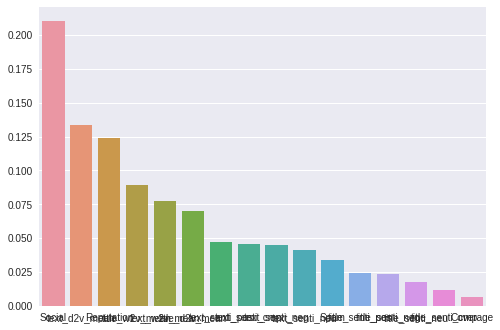

In [31]:
import seaborn as sns

feature_imp = pd.Series(clf.feature_importances_,index=list(X)).sort_values(ascending=False)
sns.barplot(y=feature_imp, x=feature_imp.index)

plt.ylabel('Importance Score')
plt.xlabel('Factor Values')
plt.legend()

plt.gcf().set_size_inches(30, 10)
plt.show()

We can now assign weights based on the importance score above

## Polynomial Equation

In [0]:
### Define polynomial function
all_data[ 'Score' ] = \
    all_data[ 'Coverage' ] * 10 + \
    all_data[ 'Reputation' ] * 10 + \
    all_data[ 'Spam' ]  * 10 + \
    all_data[ 'Social' ] * 200 + \
    all_data[ 'title_senti_neg' ] * 20 + \
    all_data[ 'title_senti_neu' ] + \
    all_data[ 'title_senti_pos'	] * 20 + \
    all_data[ 'title_senti_cmp' ] + \
    all_data[ 'text_senti_neg' ] * 10 + \
    all_data[' text_senti_neu' ] + \
    all_data[ 'text_senti_pos' ] + \
    all_data[ 'text_senti_cmp' ]

In [0]:
import matplotlib.pyplot as plt
plt.scatter(all_data.type, all_data.Score )
plt.xlabel( "Fake News" )
plt.ylabel( "Score" )

In [0]:
import matplotlib.pyplot as plt

bins = range(0,3000,100)

fake_data = all_data[all_data.type == 1 ]

plt.hist(fake_data.Score, bins, histtype='bar', rwidth=0.8, cumulative=False )
plt.xlabel( "Poly Score" )
plt.ylabel( "Count")

### Distribution for Authentic Non-fake News

In [0]:

nonfake_data = all_data[all_data.type == 0 ]

plt.hist(nonfake_data.Score, bins, histtype='bar', rwidth=0.8, cumulative=False )
plt.xlabel( "Poly Score" )
plt.ylabel( "Count")

In [0]:
url = 'https://github.com/synle/AlternusVera/releases/download/v0/fake_news_w2v_d2v_only.csv'

In [0]:
test = get_parsed_data(url)